In [1]:
import dotenv
from typing import TypedDict
from typing_extensions import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages

dotenv.load_dotenv()

True

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-3.5-turbo")

In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [5]:
graph_builder.add_node(chatbot, "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [6]:
graph = graph_builder.compile()

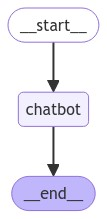

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Part 1: Chatbot without memory or search

In [11]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit"]:
        print(f"User: {user_input}")
        print(f"Assistant: Bye")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print(f"User: {user_input}")
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: How can I reach Florence from Copenhagen?
Assistant: You have several options to reach Florence from Copenhagen:

1. By plane: The most convenient way to reach Florence from Copenhagen is by taking a direct flight. Several airlines offer direct flights from Copenhagen Airport to Florence Airport. The flight takes approximately 2.5 hours.

2. By train: You can also take a train from Copenhagen to Florence. You will first need to take a train from Copenhagen to Hamburg in Germany, and then transfer to a high-speed train to Florence. The journey takes around 14-16 hours, including transfers.

3. By bus: Another option is to take a bus from Copenhagen to Florence. You can look for bus companies that offer long-distance bus services between the two cities. The journey by bus takes around 24-26 hours.

4. By car: If you prefer to drive, you can rent a car and drive from Copenhagen to Florence. The drive takes around 16-18 hours, depending on traffic and road conditions. Make sure to pl

## Part 2: Enhanced with tools

In [12]:
%pip install -U tavily-python
%pip install -U langchain_community

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.2 MB 1.6 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/2.2 MB 2.3 MB/s eta 0:00:01
   ---------- ----------------------------- 0.6/2.2 MB 4.1 MB/s eta 0:00:01
   ----------------- ---------------------- 1.0/2.2 MB 5.1 MB/s eta 0:00:01
   -------------------------- ------------- 1.5/2.2 MB 6.3 MB/s eta 0:00:01
   ------------------------------------ --- 2.1/2.2 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/983.6 kB ? eta -:--:--
   -------------------- ------------------ 522.2/983.6 kB 16.5 MB/s eta 0:00:01
   --------------------------------------  983.0/983.6 kB 12.5 MB/s eta 0:00:01
   --------------------------------------- 983.6/983.6 kB 12.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/366.3 kB ? eta -:--:--
   --------------


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What is the weather like in Copenhagen today?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Copenhagen', 'region': 'Hovedstaden', 'country': 'Denmark', 'lat': 55.67, 'lon': 12.58, 'tz_id': 'Europe/Copenhagen', 'localtime_epoch': 1721153353, 'localtime': '2024-07-16 20:09'}, 'current': {'last_updated_epoch': 1721152800, 'last_updated': '2024-07-16 20:00', 'temp_c': 19.0, 'temp_f': 66.2, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 5.6, 'wind_kph': 9.0, 'wind_degree': 350, 'wind_dir': 'N', 'pressure_mb': 1010.0, 'pressure_in': 29.83, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 78, 'cloud': 75, 'feelslike_c': 19.0, 'feelslike_f': 66.2, 'windchill_c': 16.1, 'windchill_f': 60.9, 'heatindex_c': 16.1, 'heatindex_f': 60.9, 'dewpoint_c': 15.4, 'dewpoint_f': 59.7, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 4.0, 'gust_mph': 10.1, 'gust_kph': 16.2}}"},
 {'url': 'https://www.weather25.com/europe/denmark/hovedstaden/copenh

In [3]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model_name="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [4]:
# create a basic tool node

import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            # print(f"[Debug] Received tools call in message {message}")
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}

In [5]:
tool_node = BasicToolNode(tools=[tool])

graph_builder.add_node("tools", tool_node)

In [6]:
from typing import Literal

def route_tools(
        state: State
) -> Literal["tools", "__end__"]:
    """ 
    Route to the ToolNode if the last message has tools call. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print(f"[Debug] AI Message with tools call: {ai_message}")
        return "tools"
    
    print(f"[Debug] AI Message without tools call: {ai_message}")
    return "__end__"

In [7]:
graph_builder.add_conditional_edges("chatbot", route_tools, {"tools": "tools", "__end__": "__end__"})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

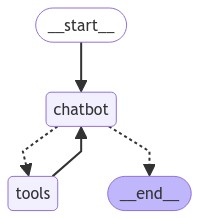

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Encountered exception {e}")

In [9]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit"]:
        print(f"User: {user_input}")
        print(f"Assistant: Bye")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print(f"User: {user_input}")
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

[Debug] AI Message with tools call: content='' additional_kwargs={'tool_calls': [{'id': 'call_6MT5NvYhpRvHaTJ7cMill6Pj', 'function': {'arguments': '{"query":"weather in Copenhagen"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 89, 'total_tokens': 109}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-a8fcf07a-4171-4b56-b4e3-086d95bb636c-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Copenhagen'}, 'id': 'call_6MT5NvYhpRvHaTJ7cMill6Pj', 'type': 'tool_call'}] usage_metadata={'input_tokens': 89, 'output_tokens': 20, 'total_tokens': 109}
User: What is the weather like in Copenhagen?
Assistant: 
User: What is the weather like in Copenhagen?
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Copenhagen', 'region': 'Hovedstaden', 'country': 'Denmark', 'lat': 